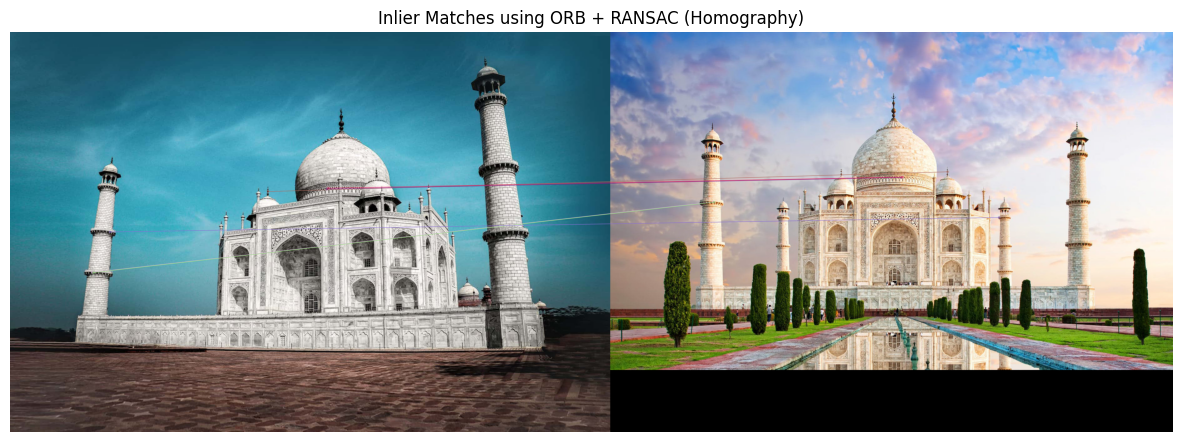

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

# Load original color images
img1_color = Image.open(r"C:\Users\ACER\Desktop\CV_TA-2\taj-1.jpg").convert('RGB')
img2_color = Image.open(r"C:\Users\ACER\Desktop\CV_TA-2\taj-2.jpg").convert('RGB')

img1_np = np.array(img1_color)
img2_np = np.array(img2_color)

# Convert to grayscale
img1_gray = cv2.cvtColor(img1_np, cv2.COLOR_RGB2GRAY)
img2_gray = cv2.cvtColor(img2_np, cv2.COLOR_RGB2GRAY)

# Detect ORB keypoints and descriptors
orb = cv2.ORB_create(nfeatures=2000)
kp1, des1 = orb.detectAndCompute(img1_gray, None)
kp2, des2 = orb.detectAndCompute(img2_gray, None)

# Brute-force matcher with Hamming distance
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Minimum matches required to compute homography
MIN_MATCH_COUNT = 10

if len(good_matches) > MIN_MATCH_COUNT:
    # Extract matched keypoint coordinates
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Find homography with RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Use the mask to filter inlier matches
    matches_mask = mask.ravel().tolist()
    inlier_matches = [good_matches[i] for i in range(len(good_matches)) if matches_mask[i]]

    # Draw inlier matches only
    result_img = cv2.drawMatches(img1_np, kp1, img2_np, kp2, inlier_matches, None,
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Display result
    plt.figure(figsize=(15, 10))
    plt.imshow(result_img)
    plt.title("Inlier Matches using ORB + RANSAC (Homography)")
    plt.axis("off")
    plt.show()
else:
    print(f"Not enough matches found - {len(good_matches)}/{MIN_MATCH_COUNT}")
